## Temp

In [1]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the csv files and index appropriately.
#ratings_small_df = pd.read_csv('./data/ratings_small.csv')
#ratings_df = pd.read_csv('./data/ratings.csv')
#links_small_df = pd.read_csv('./data/links_small.csv')
#links_df = pd.read_csv('./data/links.csv')
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')
# Reading the movies_metadata.csv file throws a DtypeWarning.
# It's the popularity feature. I deleted it.

In [3]:
print(metadata_df.id.unique())
print(metadata_df.id.dtype)
# If dtype is not int64, go to the metadata CSV and delete all entries where 'adult' is not false.
# I also deleted the adult column afterwards.

[   862   8844  15602 ...,  67758 227506 461257]
int64


In [4]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
dataframes = (keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("keywords", "credits", "movies_metadata")
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [5]:
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)

In [6]:
#movie_df.head(2).transpose()

In [7]:
# Here I'm just doing some of the same stuff "The Story of Film" did on Kaggle.
# This all makes sense, it's pretty standard.
movie_df = movie_df.drop(['imdb_id'], axis=1)
movie_df = movie_df.drop(['original_title'], axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movie_df['poster_path'] = "<img src='" + base_poster_url + movie_df['poster_path'] + "' style='height:100px;'>"

In [8]:
# Clean up from https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None
        
movie_df[['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']] = movie_df[['genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']].applymap(get_values)

In [16]:
movie_df[['cast', 'crew']] = movie_df[['cast', 'crew']].applymap(get_values)
# This takes a while to run.
# Also, it gets rid of character data and position in the crew. We may want that information.

In [17]:
# I took care of some of the NaN values already.
movie_df = movie_df[pd.notnull(movie_df['title'])]
movie_df = movie_df[pd.notnull(movie_df['keywords'])]
movie_df = movie_df[pd.notnull(movie_df['original_language'])]
movie_df = movie_df[pd.notnull(movie_df['status'])]
movie_df = movie_df[pd.notnull(movie_df['release_date'])]

print("NaN Values: \n")
print(movie_df.isnull().sum())

NaN Values: 

belongs_to_collection    41871
budget                       0
genres                       0
homepage                 38456
original_language            0
overview                   965
poster_path                345
production_companies         0
production_countries         0
release_date                 0
revenue                      0
runtime                    249
spoken_languages             0
status                       0
tagline                  25690
title                        0
video                        0
vote_average                 0
vote_count                   0
keywords                     0
cast                         0
crew                         0
dtype: int64


In [18]:
# belongs_to_collection: We may want to put in a readable format, else it's a one-hot like homepage
# homepage throws NaN when there's not a homepage it seems. Probably want to do a one-hot replacement here.
# overview:
# poster_path: The path has been filled in, the links inside it seem to work. Toy Story works, at least.
# runtime: We can probably just fill in with a mean/median.
# status: We should do some sort of hot-encoding here, then the NaNs will just be columns of 0. Will print uniques to check.
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence one-hot variable

movie_df.head().transpose()

id,2,3,5,6,11
belongs_to_collection,NaN,NaN,NaN,NaN,"{'id': 10, 'name': 'Star Wars Collection', 'po..."
budget,0,0,4000000,0,11000000
genres,"[Drama, Crime]","[Drama, Comedy]","[Crime, Comedy]","[Action, Thriller, Crime]","[Adventure, Action, Science Fiction]"
homepage,NaN,NaN,NaN,NaN,http://www.starwars.com/films/star-wars-episod...
original_language,fi,fi,en,en,en
overview,Taisto Kasurinen is a Finnish coal miner whose...,"An episode in the life of Nikander, a garbage ...",It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Princess Leia is captured and held hostage by ...
poster_path,<img src='http://image.tmdb.org/t/p/w185//gZCJ...,<img src='http://image.tmdb.org/t/p/w185//7ad4...,<img src='http://image.tmdb.org/t/p/w185//eQs5...,<img src='http://image.tmdb.org/t/p/w185//lNXm...,<img src='http://image.tmdb.org/t/p/w185//btTd...
production_companies,"[Villealfa Filmproduction Oy, Finnish Film Fou...",[Villealfa Filmproduction Oy],"[Miramax Films, A Band Apart]","[Universal Pictures, Largo Entertainment, JVC ...","[Lucasfilm, Twentieth Century Fox Film Corpora..."
production_countries,[Finland],[Finland],[United States of America],"[Japan, United States of America]",[United States of America]
release_date,10/21/1988,10/16/1986,12/9/1995,10/15/1993,5/25/1977


In [19]:
print(movie_df.status.unique())
# We probably only want to use 'Released' movies for modeling, but we could use the others as predictions.

['Released' 'In Production' 'Rumored' 'Planned' 'Post Production'
 'Canceled']


In [20]:
movie_df.describe()

,budget,revenue,runtime,vote_average,vote_count
count,4.644000e+04,4.644000e+04,46191.000000,46440.000000,46440.000000
mean,4.180341e+06,1.107134e+07,94.190427,5.621079,108.585874
std,1.730718e+07,6.392776e+07,38.359219,1.918963,487.346588
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,0.000000e+00,107.000000,6.800000,34.000000
max,3.800000e+08,2.787965e+09,1256.000000,10.000000,14075.000000


(46440, 22)


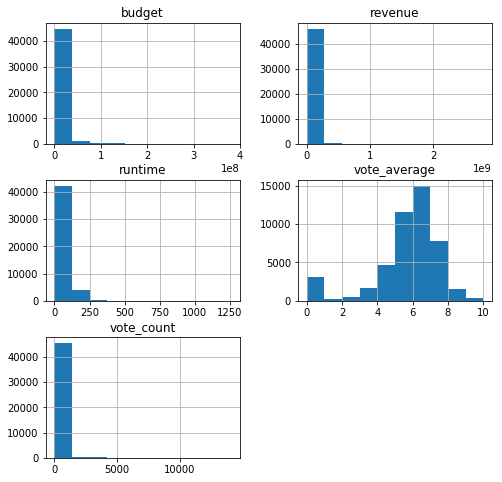

In [21]:
print(movie_df.shape)
_ = movie_df.hist(figsize=(8,8))

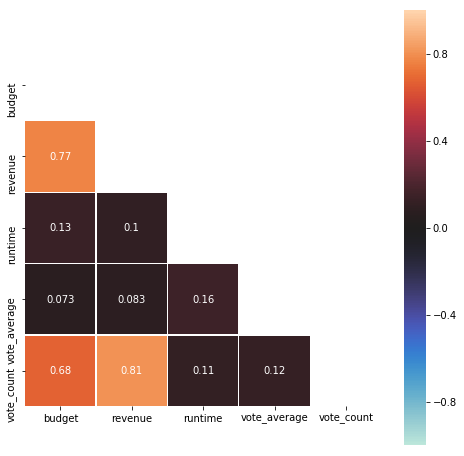

In [22]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
import seaborn as sns
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0)

In [23]:
# Toy Story Entry
print(movie_df.loc[862])

belongs_to_collection    {'id': 10194, 'name': 'Toy Story Collection', ...
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                              http://toystory.disney.com/toy-story
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path              <img src='http://image.tmdb.org/t/p/w185//rhIR...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
status                   